# GRUPO 2 - ANÁLISIS DE CALIDAD SPARK

**Grupo 2 - Integrantes:**

Freddy Marquez<br>
Jaime Montecinos<br>
Marco Ordoñez<br>
Ronald Chipana Wariste

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import Imputer, StandardScaler, VectorAssembler
from pyspark.ml.stat import Correlation

# Inicializar Spark
spark = SparkSession.builder \
    .appName("DataQualityExample") \
    .config("spark.sql.adaptive.enabled", "true") \
    .getOrCreate()

# Cargar datos
df_spark = spark.read.option("header", "true").csv("/content/drive/MyDrive/Colab Notebooks/Modulo7/data/fake_job_postings.csv", inferSchema=True)
df_spark.show(5)

+------+--------------------+------------------+----------+------------+--------------------+--------------------+--------------------+--------------------+-------------+----------------+-------------+---------------+-------------------+------------------+--------------------+--------------------+----------+
|job_id|               title|          location|department|salary_range|     company_profile|         description|        requirements|            benefits|telecommuting|has_company_logo|has_questions|employment_type|required_experience|required_education|            industry|            function|fraudulent|
+------+--------------------+------------------+----------+------------+--------------------+--------------------+--------------------+--------------------+-------------+----------------+-------------+---------------+-------------------+------------------+--------------------+--------------------+----------+
|     1|    Marketing Intern|  US, NY, New York| Marketing|        NUL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# analisis de calidad

def spark_quality_analysis(df):
    """Análisis de calidad para Spark DataFrame"""
    print("=== ANÁLISIS DE CALIDAD SPARK ===")

    # Conteo de registros
    print(f"Total registros: {df.count()}")
    print(f"Total columnas: {len(df.columns)}")

    # Análisis de nulls por columna
    null_counts = df.select([
        count(when(isnan(c) | col(c).isNull(), c)).alias(c)
        for c in df.columns
    ]).collect()[0]

    print("\nVALORES NULOS POR COLUMNA:")
    for col_name, null_count in null_counts.asDict().items():
        if null_count > 0:
            percentage = (null_count / df.count()) * 100
            print(f"{col_name}: {null_count} ({percentage:.2f}%)")

    # Duplicados
    total_rows = df.count()
    unique_rows = df.distinct().count()
    duplicates = total_rows - unique_rows
    print(f"\nRegistros duplicados: {duplicates}")

    return df

spark_quality_analysis(df_spark)

=== ANÁLISIS DE CALIDAD SPARK ===
Total registros: 17880
Total columnas: 18

VALORES NULOS POR COLUMNA:
location: 346 (1.94%)
department: 11547 (64.58%)
salary_range: 15011 (83.95%)
company_profile: 3308 (18.50%)
description: 1 (0.01%)
requirements: 2573 (14.39%)
benefits: 6966 (38.96%)
telecommuting: 89 (0.50%)
has_company_logo: 29 (0.16%)
has_questions: 30 (0.17%)
employment_type: 3292 (18.41%)
required_experience: 6723 (37.60%)
required_education: 7748 (43.33%)
industry: 4831 (27.02%)
function: 6317 (35.33%)
fraudulent: 176 (0.98%)

Registros duplicados: 0


DataFrame[job_id: int, title: string, location: string, department: string, salary_range: string, company_profile: string, description: string, requirements: string, benefits: string, telecommuting: string, has_company_logo: string, has_questions: string, employment_type: string, required_experience: string, required_education: string, industry: string, function: string, fraudulent: string]

=== ANÁLISIS DE CALIDAD SPARK ===
Total registros: 17880
Total columnas: 18

VALORES NULOS POR COLUMNA:
location: 346 (1.94%)
department: 11547 (64.58%)
salary_range: 15011 (83.95%)
company_profile: 3308 (18.50%)
description: 1 (0.01%)
requirements: 2573 (14.39%)
benefits: 6966 (38.96%)
telecommuting: 89 (0.50%)
has_company_logo: 29 (0.16%)
has_questions: 30 (0.17%)
employment_type: 3292 (18.41%)
required_experience: 6723 (37.60%)
required_education: 7748 (43.33%)
industry: 4831 (27.02%)
function: 6317 (35.33%)
fraudulent: 176 (0.98%)

Registros duplicados: 0


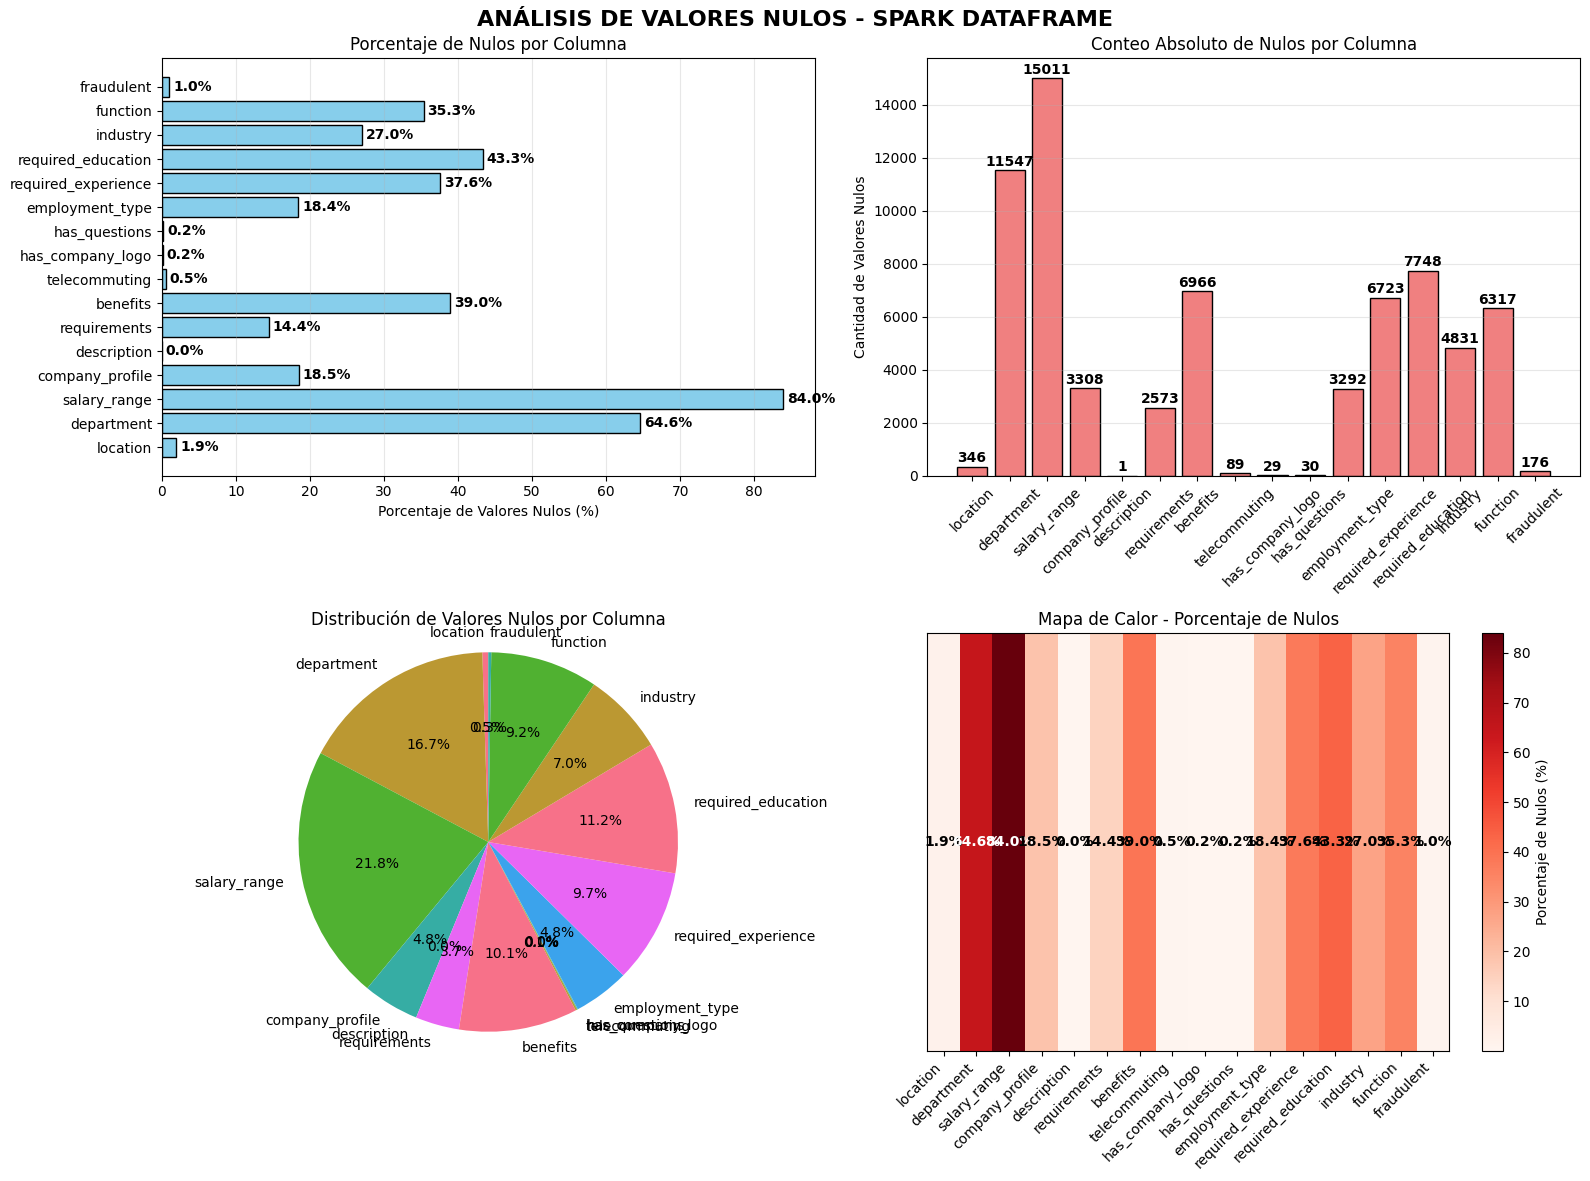

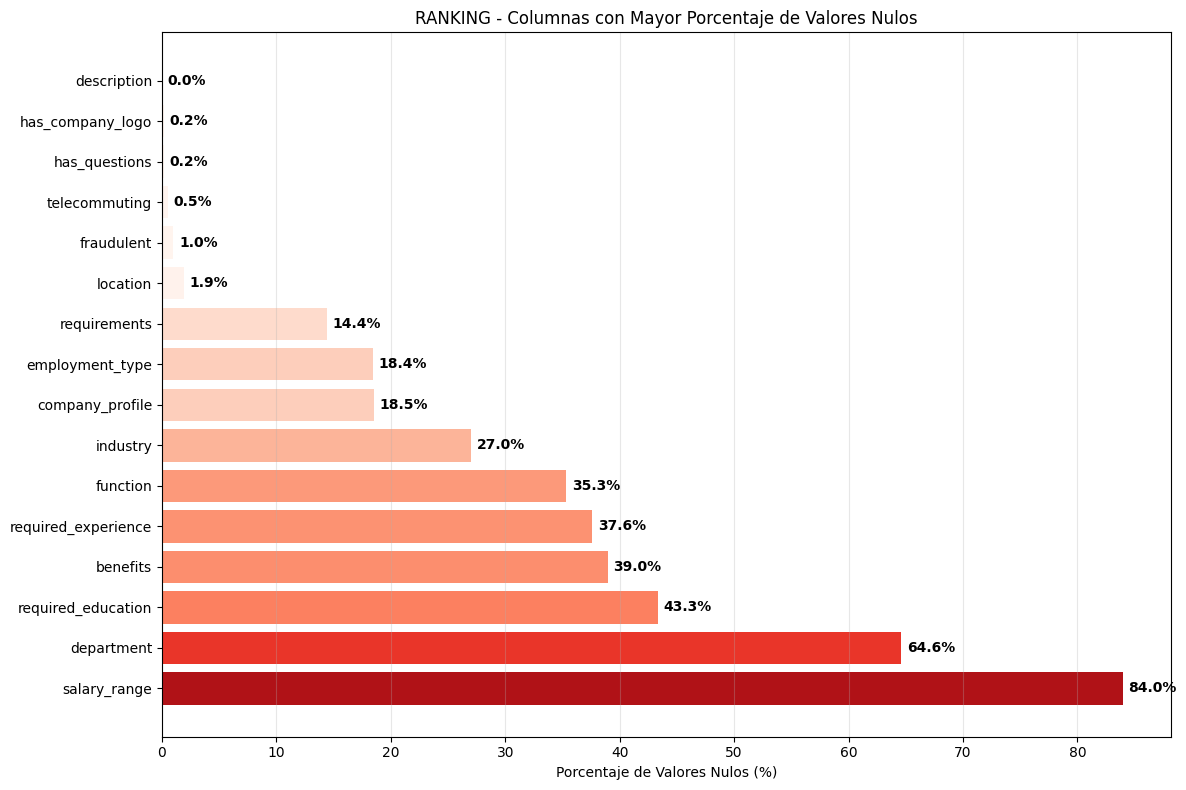

DataFrame[job_id: int, title: string, location: string, department: string, salary_range: string, company_profile: string, description: string, requirements: string, benefits: string, telecommuting: string, has_company_logo: string, has_questions: string, employment_type: string, required_experience: string, required_education: string, industry: string, function: string, fraudulent: string]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def spark_quality_analysis_visual(df):
    """Análisis de calidad para Spark DataFrame con visualizaciones"""
    print("=== ANÁLISIS DE CALIDAD SPARK ===")

    # Conteo de registros
    total_registros = df.count()
    print(f"Total registros: {total_registros}")
    print(f"Total columnas: {len(df.columns)}")

    # Análisis de nulls por columna
    from pyspark.sql.functions import count, when, isnan, col

    null_counts = df.select([
        count(when(isnan(c) | col(c).isNull(), c)).alias(c)
        for c in df.columns
    ]).collect()[0]

    # Crear listas para la visualización
    columnas = []
    nulos_count = []
    porcentajes = []

    print("\nVALORES NULOS POR COLUMNA:")
    for col_name, null_count in null_counts.asDict().items():
        if null_count > 0:
            percentage = (null_count / total_registros) * 100
            columnas.append(col_name)
            nulos_count.append(null_count)
            porcentajes.append(percentage)
            print(f"{col_name}: {null_count} ({percentage:.2f}%)")

    # Duplicados
    unique_rows = df.distinct().count()
    duplicates = total_registros - unique_rows
    print(f"\nRegistros duplicados: {duplicates}")

    # Visualización
    if columnas:  # Solo crear gráficos si hay columnas con nulos
        crear_visualizaciones(columnas, nulos_count, porcentajes, total_registros)

    return df

def crear_visualizaciones(columnas, nulos_count, porcentajes, total_registros):
    """Crea visualizaciones para los datos de nulos"""

    # Configurar estilo
    plt.style.use('default')
    sns.set_palette("husl")

    # Crear figura con subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('ANÁLISIS DE VALORES NULOS - SPARK DATAFRAME', fontsize=16, fontweight='bold')

    # Gráfico 1: Barras horizontales (porcentajes)
    bars1 = ax1.barh(columnas, porcentajes, color='skyblue', edgecolor='black')
    ax1.set_xlabel('Porcentaje de Valores Nulos (%)')
    ax1.set_title('Porcentaje de Nulos por Columna')
    ax1.grid(axis='x', alpha=0.3)

    # Añadir etiquetas de valor en las barras
    for bar, porcentaje in zip(bars1, porcentajes):
        ax1.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{porcentaje:.1f}%', ha='left', va='center', fontweight='bold')

    # Gráfico 2: Barras verticales (conteo absoluto)
    bars2 = ax2.bar(columnas, nulos_count, color='lightcoral', edgecolor='black')
    ax2.set_ylabel('Cantidad de Valores Nulos')
    ax2.set_title('Conteo Absoluto de Nulos por Columna')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)

    # Añadir etiquetas de valor en las barras
    for bar, count_val in zip(bars2, nulos_count):
        ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{count_val}', ha='center', va='bottom', fontweight='bold')

    # Gráfico 3: Pie chart (distribución de nulos)
    ax3.pie(porcentajes, labels=columnas, autopct='%1.1f%%', startangle=90)
    ax3.set_title('Distribución de Valores Nulos por Columna')
    ax3.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    # Gráfico 4: Heatmap de porcentajes
    # Crear matriz para heatmap
    heatmap_data = np.array(porcentajes).reshape(1, -1)
    im = ax4.imshow(heatmap_data, cmap='Reds', aspect='auto')

    # Configurar heatmap
    ax4.set_xticks(range(len(columnas)))
    ax4.set_xticklabels(columnas, rotation=45, ha='right')
    ax4.set_yticks([])
    ax4.set_title('Mapa de Calor - Porcentaje de Nulos')

    # Añadir anotaciones en el heatmap
    for i in range(len(columnas)):
        ax4.text(i, 0, f'{porcentajes[i]:.1f}%', ha='center', va='center',
                fontweight='bold', color='white' if porcentajes[i] > 50 else 'black')

    # Añadir colorbar
    plt.colorbar(im, ax=ax4, label='Porcentaje de Nulos (%)')

    # Ajustar layout
    plt.tight_layout()
    plt.show()

    # Gráfico adicional: Ranking de columnas con más nulos
    plt.figure(figsize=(12, 8))

    # Ordenar datos para mejor visualización
    sorted_indices = np.argsort(porcentajes)[::-1]
    sorted_columns = [columnas[i] for i in sorted_indices]
    sorted_percentages = [porcentajes[i] for i in sorted_indices]

    bars = plt.barh(sorted_columns, sorted_percentages,
                   color=plt.cm.Reds(np.array(sorted_percentages)/100))

    plt.xlabel('Porcentaje de Valores Nulos (%)')
    plt.title('RANKING - Columnas con Mayor Porcentaje de Valores Nulos')
    plt.grid(axis='x', alpha=0.3)

    # Añadir etiquetas
    for i, (bar, porcentaje) in enumerate(zip(bars, sorted_percentages)):
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
                f'{porcentaje:.1f}%', ha='left', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Ejecutar el análisis
spark_quality_analysis_visual(df_spark)

In [ ]:
# Limpieza Distribuida

def spark_data_cleaning(df):
    """Pipeline de limpieza para Spark"""

    # 1. Eliminar registros con muchos nulls
    threshold = 0.5  # Eliminar filas con >50% nulls
    min_non_null = int(threshold * len(df.columns))
    df_clean = df.dropna(thresh=min_non_null)

    # 2. Imputación por columna
    numeric_cols = [field.name for field in df_clean.schema.fields
                   if field.dataType in [IntegerType(), DoubleType(), FloatType()]]

    # Imputar con mediana
    for col_name in numeric_cols:
        median_val = df_clean.approxQuantile(col_name, [0.5], 0.01)[0]
        df_clean = df_clean.na.fill({col_name: median_val})

    # Imputar categóricas con moda
    string_cols = [field.name for field in df_clean.schema.fields
                  if field.dataType == StringType()]

   # for col_name in string_cols:
   #     mode_val = df_clean.groupBy(col_name).count().orderBy(desc("count")).first()[0]
   #     df_clean = df_clean.na.fill({col_name: mode_val})
    for col_name in string_cols:
      print(col_name)
      mode_val = df_clean.filter(col(col_name).isNotNull()).groupBy(col_name).count().orderBy(desc("count")).first()[0]
      df_clean = df_clean.na.fill({col_name: mode_val})


    # 3. Eliminar duplicados
    df_clean = df_clean.dropDuplicates()

    # 4. Detección de outliers usando IQR
    for col_name in numeric_cols:
        quantiles = df_clean.approxQuantile(col_name, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        df_clean = df_clean.filter(
            (col(col_name) >= lower_bound) &
            (col(col_name) <= upper_bound)
        )
    df_clean.show(5)
    return df_clean

df_spark_clean = spark_data_cleaning(df_spark)
print(f"Registros después de limpieza: {df_spark_clean.count()}")

title
location
department
salary_range
company_profile
description
requirements
benefits
telecommuting
has_company_logo
has_questions
employment_type
required_experience
required_education
industry
function
fraudulent
+------+--------------------+-----------------+------------+------------+--------------------+--------------------+--------------------+--------------------+-------------+----------------+-------------+---------------+-------------------+------------------+--------------------+--------------------+----------+
|job_id|               title|         location|  department|salary_range|     company_profile|         description|        requirements|            benefits|telecommuting|has_company_logo|has_questions|employment_type|required_experience|required_education|            industry|            function|fraudulent|
+------+--------------------+-----------------+------------+------------+--------------------+--------------------+--------------------+--------------------+---

In [ ]:
# GREAT EXPECTATIONS


# Setup Great Expectations

import great_expectations as ge
from great_expectations.core.batch import RuntimeBatchRequest
from great_expectations.data_context import BaseDataContext
from great_expectations.data_context.types.base import DataContextConfig

# Inicializar contexto
context = ge.get_context()

# Convertir pandas DataFrame a GE Dataset
ge_df = ge.from_pandas(df_clean)

In [ ]:
# Definir Expectativas

def create_data_expectations(ge_df):
    """Define expectativas de calidad para el dataset"""

    # 1. Expectativas básicas de estructura
    ge_df.expect_table_row_count_to_be_between(min_value=1000, max_value=100000)
    ge_df.expect_table_column_count_to_equal(value=10)

    # 2. Expectativas de completitud
    ge_df.expect_column_values_to_not_be_null(column="product_id")
    ge_df.expect_column_values_to_not_be_null(column="price")

    # 3. Expectativas de valores únicos
    ge_df.expect_column_values_to_be_unique(column="product_id")

    # 4. Expectativas de rango
    ge_df.expect_column_values_to_be_between(
        column="price",
        min_value=0,
        max_value=10000
    )

    ge_df.expect_column_values_to_be_between(
        column="rating",
        min_value=1,
        max_value=5
    )

    # 5. Expectativas de formato
    ge_df.expect_column_values_to_match_regex(
        column="email",
        regex=r'^[a-zA-Z0-9._%+-]+@[a-zA-Z0-9.-]+\.[a-zA-Z]{2,}$'
    )

    # 6. Expectativas de categorías
    ge_df.expect_column_values_to_be_in_set(
        column="category",
        value_set=["Electronics", "Clothing", "Books", "Home", "Sports"]
    )

    # 7. Expectativas estadísticas
    ge_df.expect_column_mean_to_be_between(
        column="rating",
        min_value=3.0,
        max_value=4.5
    )

    return ge_df

# Aplicar expectativas
ge_df_with_expectations = create_data_expectations(ge_df)

In [ ]:
# Validar y Generar Reporte

# Ejecutar validación
validation_result = ge_df_with_expectations.validate()

# Mostrar resultados
print("=== RESULTADOS DE VALIDACIÓN ===")
print(f"Validación exitosa: {validation_result.success}")
print(f"Total expectativas: {len(validation_result.results)}")

# Detalles de fallos
failed_expectations = [
    result for result in validation_result.results
    if not result.success
]

print(f"Expectativas fallidas: {len(failed_expectations)}")

for failed in failed_expectations:
    print(f"❌ {failed.expectation_config.expectation_type}")
    print(f"   Columna: {failed.expectation_config.kwargs.get('column', 'N/A')}")
    print(f"   Detalle: {failed.result}")

In [ ]:
# DATA QUALITY DASHBOARD

# Crear Visualizaciones de Calidad

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.offline as pyo

def create_quality_dashboard(df, validation_result):
    """Crea dashboard interactivo de calidad"""

    # 1. Completitud por columna
    missing_data = df.isnull().sum().reset_index()
    missing_data.columns = ['Column', 'Missing_Count']
    missing_data['Missing_Percentage'] = (missing_data['Missing_Count'] / len(df)) * 100

    fig1 = px.bar(missing_data, x='Column', y='Missing_Percentage',
                  title='Completitud por Columna (%)')
    fig1.update_layout(xaxis_tickangle=-45)

    # 2. Distribución de calidad por expectativas
    success_count = sum(1 for result in validation_result.results if result.success)
    fail_count = len(validation_result.results) - success_count

    fig2 = go.Figure(data=[
        go.Pie(labels=['Pasadas', 'Fallidas'],
               values=[success_count, fail_count],
               hole=0.3)
    ])
    fig2.update_layout(title='Distribución de Expectativas')

    # 3. Outliers por columna numérica
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    fig3 = make_subplots(rows=2, cols=2,
                        subplot_titles=[f'Outliers en {col}' for col in numeric_cols[:4]])

    for i, col in enumerate(numeric_cols[:4]):
        row = (i // 2) + 1
        col_pos = (i % 2) + 1

        fig3.add_trace(
            go.Box(y=df[col], name=col),
            row=row, col=col_pos
        )

    # 4. Correlación entre variables numéricas
    corr_matrix = df[numeric_cols].corr()
    fig4 = px.imshow(corr_matrix,
                     title='Matriz de Correlación',
                     color_continuous_scale='RdBu_r')

    # Mostrar gráficos
    fig1.show()
    fig2.show()
    fig3.show()
    fig4.show()

    return fig1, fig2, fig3, fig4

# Crear dashboard
dashboard_figs = create_quality_dashboard(df_clean, validation_result)


NameError: name 'df_clean' is not defined

In [ ]:
# Reporte HTML Automatizado

def generate_html_report(df, validation_result, output_path="quality_report.html"):
    """Genera reporte HTML completo"""

    html_template = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Data Quality Report</title>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .header { background-color: #f0f0f0; padding: 20px; }
            .metric { display: inline-block; margin: 10px; padding: 15px;
                     background-color: #e8f4fd; border-radius: 5px; }
            .success { color: green; }
            .error { color: red; }
            table { border-collapse: collapse; width: 100%; }
            th, td { border: 1px solid #ddd; padding: 8px; text-align: left; }
            th { background-color: #f2f2f2; }
        </style>
    </head>
    <body>
        <div class="header">
            <h1>Data Quality Report</h1>
            <p>Generado: {timestamp}</p>
        </div>

        <h2>Métricas Generales</h2>
        <div class="metric">
            <strong>Total Registros:</strong> {total_rows}
        </div>
        <div class="metric">
            <strong>Total Columnas:</strong> {total_columns}
        </div>
        <div class="metric">
            <strong>Registros Duplicados:</strong> {duplicates}
        </div>
        <div class="metric">
            <strong>Expectativas Pasadas:</strong>
            <span class="success">{success_count}</span>
        </div>
        <div class="metric">
            <strong>Expectativas Fallidas:</strong>
            <span class="error">{fail_count}</span>
        </div>

        <h2>Completitud por Columna</h2>
        <table>
            <tr><th>Columna</th><th>Valores Faltantes</th><th>Porcentaje</th></tr>
            {completeness_table}
        </table>

        <h2>Expectativas Fallidas</h2>
        {failed_expectations_html}

    </body>
    </html>
    """

    # Calcular métricas
    total_rows = len(df)
    total_columns = len(df.columns)
    duplicates = df.duplicated().sum()
    success_count = sum(1 for result in validation_result.results if result.success)
    fail_count = len(validation_result.results) - success_count

    # Tabla de completitud
    missing_data = df.isnull().sum()
    completeness_rows = []
    for col, missing in missing_data.items():
        if missing > 0:
            percentage = (missing / total_rows) * 100
            completeness_rows.append(
                f"<tr><td>{col}</td><td>{missing}</td><td>{percentage:.2f}%</td></tr>"
            )

    completeness_table = "".join(completeness_rows)

    # Expectativas fallidas
    failed_expectations = [
        result for result in validation_result.results if not result.success
    ]

    failed_html = "<ul>"
    for failed in failed_expectations:
        failed_html += f"<li><strong>{failed.expectation_config.expectation_type}</strong>: "
        failed_html += f"{failed.result.get('partial_unexpected_list', 'Ver detalles')}</li>"
    failed_html += "</ul>"

    # Generar HTML
    html_content = html_template.format(
        timestamp=pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S'),
        total_rows=total_rows,
        total_columns=total_columns,
        duplicates=duplicates,
        success_count=success_count,
        fail_count=fail_count,
        completeness_table=completeness_table,
        failed_expectations_html=failed_html
    )

    with open(output_path, 'w', encoding='utf-8') as f:
        f.write(html_content)

    print(f"Reporte generado: {output_path}")

# Generar reporte
generate_html_report(df_clean, validation_result)